In [1]:
import torch
import torch.hub
import torchvision.transforms as transforms

from transformers import pipeline

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image, ImageEnhance




In [2]:
model = torch.hub.load('intel-isl/MiDaS', 'MiDaS')
model.eval()

Using cache found in C:\Users\siddu/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\siddu/.cache\torch\hub\facebookresearch_WSL-Images_main


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [3]:
def torch_depth(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        image_tensor = image_tensor.type(torch.FloatTensor)
        depth_map = model(image_tensor)

    depth_prediction = depth_map[0, depth_map.shape[1] // 2, depth_map.shape[2] // 2].item()
    
    keys = ["Severe Hazard Pothole","Moderate Risk Pothole","Minor Issue Pothole"]
    if depth_prediction>2000:
        dict = {3:f"{keys[0]}"}
        return(dict)
    elif depth_prediction>1500:
        dict = {2:f"{keys[1]}"}
        return(dict)
    else:
        dict = {1:f"{keys[2]}"}
    
    return depth_prediction

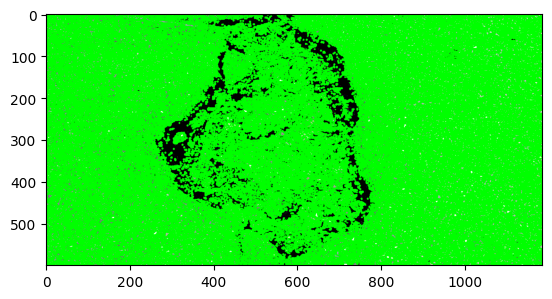

In [10]:
def llm_depth(image_path):
    pipe = pipeline(task="depth-estimation", model="Intel/dpt-large")

    #image_path = "C:\\Users\\siddu\\Desktop\\validation\\potholes\\34.jpg"
    image = Image.open(image_path)
    image = ImageEnhance.Contrast(image).enhance(2)  
    image = ImageEnhance.Sharpness(image).enhance(2)  

    result = pipe(image)
    depth = result["depth"]


    depth_array = np.array(depth)
    depth_normalized = (255 * (depth_array - np.min(depth_array)) / (np.max(depth_array) - np.min(depth_array))).astype(np.uint8)
    depth_image = Image.fromarray(depth_normalized)
    depth_image.save("Depth_Map.png")

    plt.imshow(depth_normalized, cmap='gray')
    plt.colorbar()
    plt.show()

    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image_cv, contours, -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.show()

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        pothole_region = depth_array[y:y+h, x:x+w]

        min_depth = np.min(pothole_region)
        max_depth = np.max(pothole_region)
        avg_depth = np.mean(pothole_region)

        return([max_depth, min_depth, avg_depth])

    else:
        print("No pothole detected.")

In [5]:
def display_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

Depth
{3: 'Severe Hazard Pothole'}


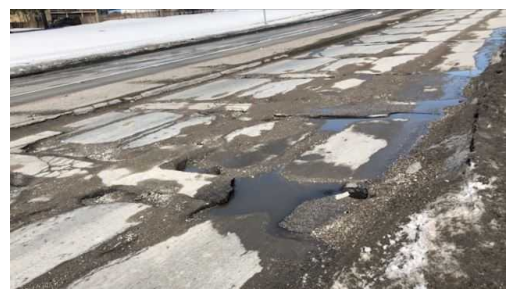

Depth
{3: 'Severe Hazard Pothole'}


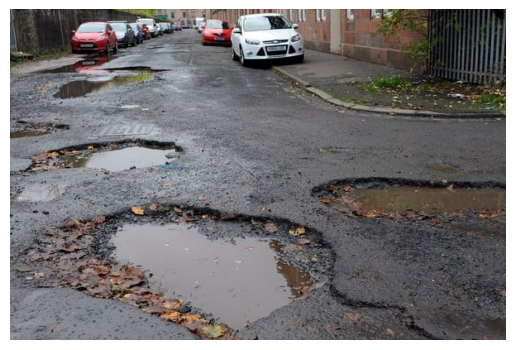

Depth
{3: 'Severe Hazard Pothole'}


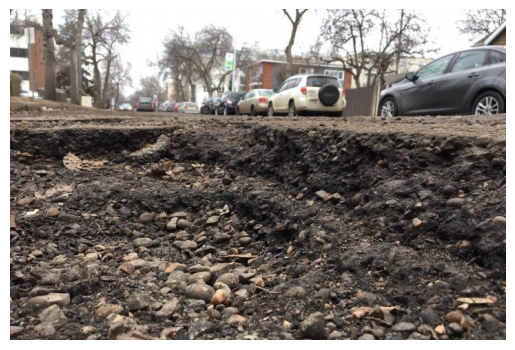

Depth
{3: 'Severe Hazard Pothole'}


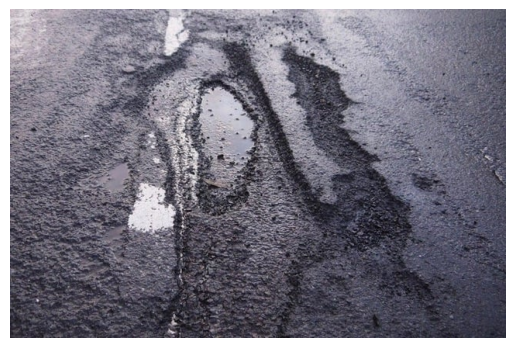

Depth
1432.954833984375


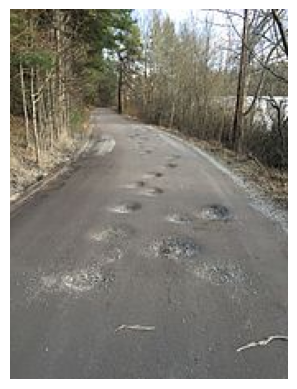

Depth
{2: 'Moderate Risk Pothole'}


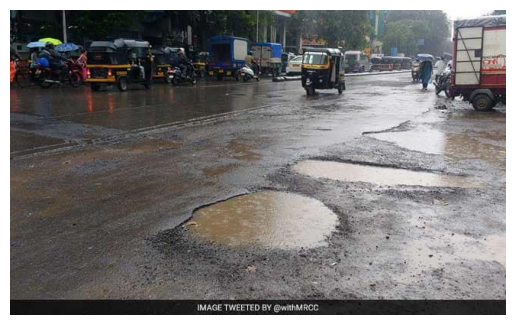

Depth
{3: 'Severe Hazard Pothole'}


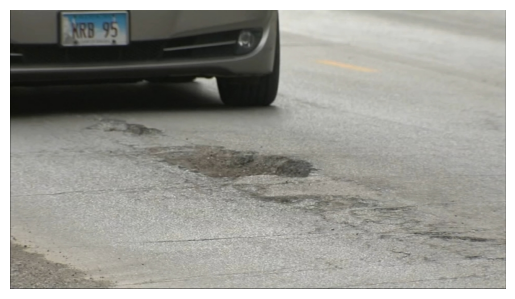

Depth
{3: 'Severe Hazard Pothole'}


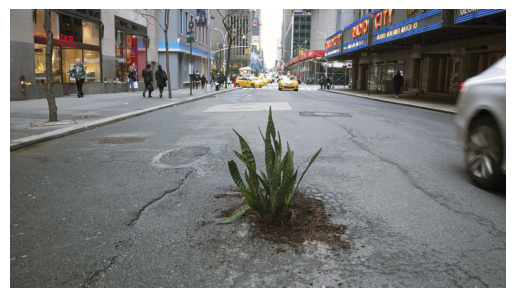

Depth
{3: 'Severe Hazard Pothole'}


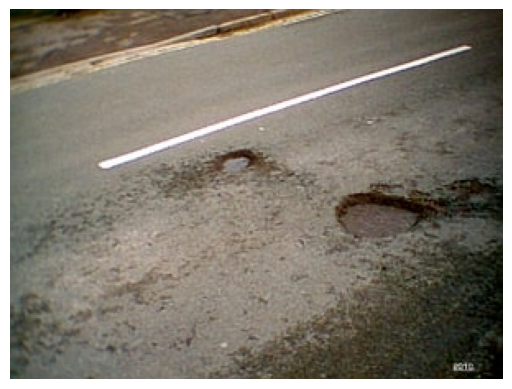

Depth
{2: 'Moderate Risk Pothole'}


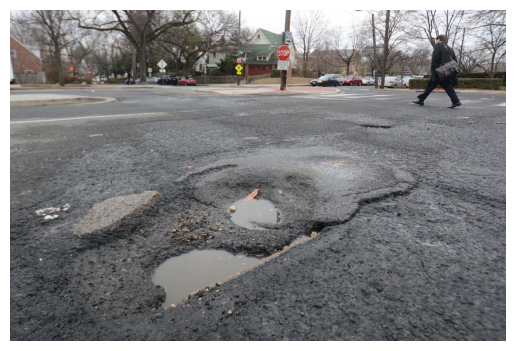

In [6]:
for i in range(10):
    img = random.randint(1,329)
    path = f"C:\\Users\\siddu\\Desktop\\validation\\potholes\\{img}.jpg"

    print(torch_depth(path))
    display_image(path)